# SPARC-4 mini-pipeline tools
## Science image reduction

This notebook shows an example for reducing a series of scientific images using the SPARC4 pipeline.

* Eder Martioli, LNA 16 Feb 2023

In [8]:
import os,sys
path_parent = os.path.dirname(os.getcwd())
# path_parent = "/Volumes/Samsung_T5/sparc4-pipeline/"
sys.path.append(path_parent)  
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_utils as s4utils
import sparc4_params

### User inputs

In [3]:
# set night directory name
NIGHTDIR = '20221104'
# set SPARC4 channel
CHANNEL = 3  # 1, 2, 3 or 4
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "CR7"
# whether or not to force reduction even if product already exists
FORCE = True

### Preparatory procedures
Below are some preparatory procedures for defining data directories and product file names.

In [4]:
# get SPARC4 pipeline parameters
p = sparc4_params.load_sparc4_parameters()
# set raw data root directory (where raw data will be searched)
p['ROOTDATADIR'] = "/Volumes/Samsung_T5/Data/SPARC4/comissioning_nov22/"
# set reduction directory name
p['ROOTREDUCEDIR'] = '/Volumes/Samsung_T5/Data/SPARC4/comissioning_nov22/reduced'
# if reduced dir doesn't exist create one
if not os.path.exists(p['ROOTREDUCEDIR']) :
    os.mkdir(p['ROOTREDUCEDIR'])
    
# identify files for reduction
p = s4utils.identify_files(p, NIGHTDIR, print_report=False)    

# set full paths for a given night and channel
data_dir = p['data_directories'][CHANNEL-1]
ch_reduce_dir = '{}/sparc4acs{}/'.format(p['ROOTREDUCEDIR'],CHANNEL)
reduce_dir = '{}/sparc4acs{}/{}/'.format(p['ROOTREDUCEDIR'],CHANNEL,NIGHTDIR)

# set master bias product file name
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reduce_dir,NIGHTDIR,CHANNEL)
# set master flat product file name
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reduce_dir,NIGHTDIR,CHANNEL)

# set reference image for astrometry
p["ASTROM_REF_IMG"] = p["ASTROM_REF_IMGS"][CHANNEL-1]

### Start reduction here

1. Reduce all scientific exposures in `PHOTOMETRY` mode for the selected object ID

In [ ]:
for obj in p['objsInPhot'][CHANNEL-1] :
    if obj == OBJECTID :    
        # set suffix for stack product
        stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))
        
        # reduce science data and calculate stack
        p = s4pipelib.reduce_science_images(p, 
                                            p['objsInPhotdata'][CHANNEL-1][obj], 
                                            data_dir=data_dir, 
                                            reduce_dir=reduce_dir, 
                                            force=FORCE, 
                                            match_frames=True, 
                                            stack_suffix=stack_suffix, 
                                            polarimetry=False)
        
        # plot phot stack product
        s4plt.plot_sci_frame(p['OBJECT_STACK'], nstars=10)

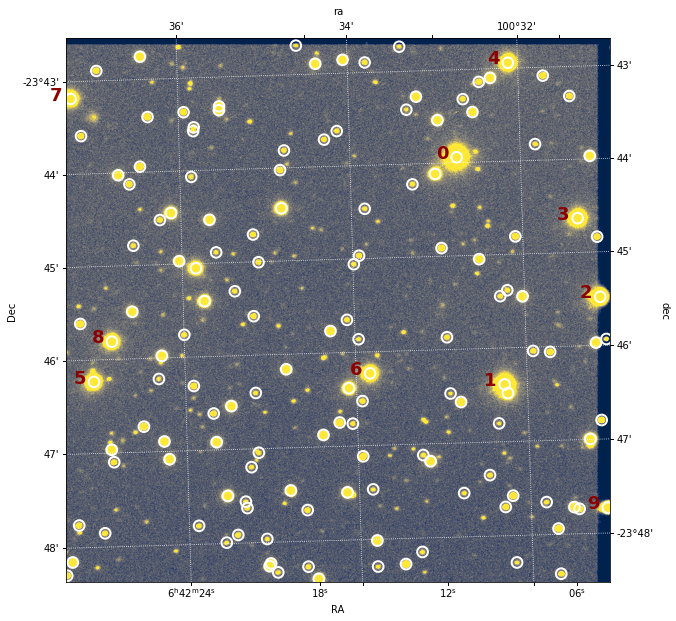

In [5]:
if 'OBJECT_STACK' not in p.keys() :
    p['OBJECT_STACK'] = '{}/{}_s4c{}_{}_stack.fits'.format(reduce_dir,NIGHTDIR,CHANNEL,OBJECTID)
s4plt.plot_sci_frame(p['OBJECT_STACK'], 
                     cat_ext=9, 
                     nstars=10, 
                     percentile=97., 
                     use_sky_coords=True)

Pixel scale: x: 0.342 arcsec/pix y: 0.341 arcsec/pix
Median FWHM: 6.692 pix   Master PSF FWHM: 6.994 pix


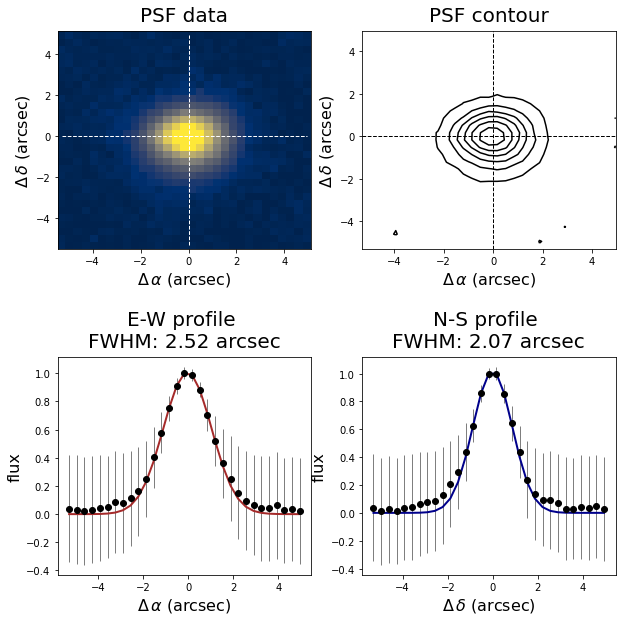

In [6]:
psf = s4pipelib.psf_analysis(p['OBJECT_STACK'], 
                             aperture=10, 
                             half_windowsize=15, 
                             polarimetry=False, 
                             plot=False, 
                             verbose=False)

In [ ]:
psf = s4pipelib.psf_analysis("/Volumes/Samsung_T5/Data/SPARC4/comissioning_nov22/reduced/sparc4acs1/20221104/20221105_s4c1_cr7_000010_proc.fits", 
                             aperture=10, 
                             half_windowsize=15,
                             nsources=0,
                             polarimetry=False, 
                             plot=False, 
                             verbose=False)

2. Reduce all scientific exposures in `POLARIMETRY HALF-WAVE` mode for the selected object ID

In [ ]:
for obj in p['objsInPolarl2'][CHANNEL-1] :
    if obj == OBJECTID :
        # set suffix for stack product        
        stack_suffix = "{}_s4c{}_{}_POL_L2".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))
        
        # reduce science data and calculate stack
        p = s4pipelib.reduce_science_images(p, 
                                            p['objsInPolarL2data'][CHANNEL-1][obj], 
                                            data_dir=data_dir, 
                                            reduce_dir=reduce_dir, 
                                            force=FORCE, 
                                            match_frames=True, 
                                            stack_suffix=stack_suffix, 
                                            polarimetry=True)
        
        # plot pol l/2 stack product
        s4plt.plot_sci_frame(p['OBJECT_STACK'], nstars=20)

3. Reduce all scientific exposures in `POLARIMETRY QUARTER-WAVE` mode for the selected object ID

In [ ]:
for obj in p['objsInPolarl4'][CHANNEL-1] :
    if obj == OBJECTID :    
        stack_suffix = "{}_s4c{}_{}_POL_L4".format(NIGHTDIR,p['CHANNELS'][CHANNEL-1],obj.replace(" ",""))
        # reduce science data and calculate stack
        p = s4pipelib.reduce_science_images(p, 
                                            p['objsInPolarL4data'][CHANNEL-1][obj], 
                                            data_dir=data_dir, 
                                            reduce_dir=reduce_dir, 
                                            force=FORCE, 
                                            match_frames=True, 
                                            stack_suffix=stack_suffix, 
                                            polarimetry=True)
        # plot pol l/4 stack product        
        s4plt.plot_sci_polar_frame(p['OBJECT_STACK'])